In [ ]:
#Importing Dependencies
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from ipywidgets import interactive


%matplotlib inline

In [2]:
ierror = 0
vprev = 0
#PID Module that takes input: v(Velocity),SP(Set Point), params(Tuning parameters) and delta_t(Time Interval)
#and returns: u(Gas Peddal)
def PID(v, SP, params, delta_t):
    global ierror
    global vprev
    error = SP - v
    ierror = ierror + error*delta_t
    derror = (v - vprev)/delta_t

    #kp,ki,kd = get_parameters()
    kp=params["kp"]
    ki=params["ki"]
    kd=params["kd"]
    
    u = kp*error + ki*ierror - kd*derror
    
    #Regenerative Breaking and Anti-Reset Integral Windup
    if u>=100:
        u = 100
        ierror = ierror - error*delta_t
    elif u<=-50:
        u = -50
        ierror = ierror - error*delta_t
    
    vprev = v
    return u

In [3]:
#Function used to describe the Car Model
def control_system(v, t, u):
    #Constants for Process Equation
    Cd = 0.24
    rho = 1.225
    m = 500
    A = 5
    Fp = 30
    load = 200
    #Process equation
    dv = (Fp*u - (rho*A*Cd*(v**2))/2)/(m + load)
    return dv

In [4]:
#Here we Simulate out Model+PID controller over time-step of 0.1 Seconds
def simulation(kp=1/1.2,ki=1/(1.2*20),kd=1):
    #PID Tuning parameters
    params = {'kp':kp,'ki':ki,'kd':kd}

    #Time-Span with time-step of 0.1 Seconds
    t = np.linspace(0,300,3010)
    delta_t = t[1] - t[0]

    #Initialising given velocity
    v0 = 0
    #Storing velocity responses
    v = np.ones(len(t))*v0

    #Storing Gas-Peddal responses
    u = np.zeros(len(t))

    #Step-Adding through set points(of velocity)
    SP = np.ones(len(t))*25
    SP[500: 1000] = 0
    SP[1000: 1500] = 15
    SP[1500: 2000] = 20
    SP[2000: ] = 10

    #Simulating the PID+Model system over time-step of 0.1s
    for i in range(len(t)-1):
        #Here we can also call a function to input PID parameters at each time-step
        #params = get_pid_parameters()
        u[i+1] = PID(v[i],SP[i],params, delta_t)
        y = odeint(control_system, v[i], t[i:i+2], args=(u[i+1],))
        v[i+1] = y[-1]

    #Plotting
    plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(t, v, 'r-', label='v')
    plt.plot(t, SP, 'b--', label='SP')
    plt.ylabel('Velocity')
    plt.legend(loc='best')
    plt.subplot(2,1,2)
    plt.plot(t, u, 'k', label='u')
    plt.ylabel('Gas Peddal')
    plt.xlabel('Time')
    plt.legend(loc='best')

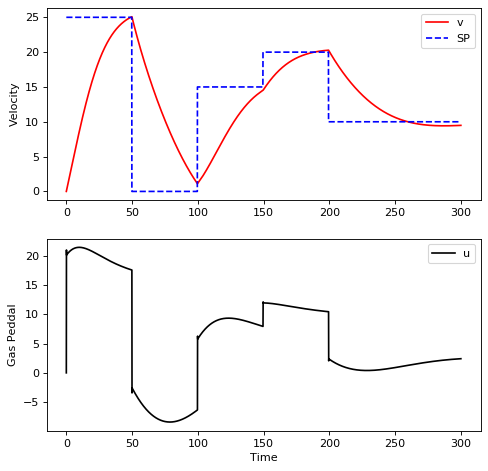

In [5]:
interactive_plt = interactive(simulation, kp=(-20.0,20.0), ki=(-20.0,20.0), kd=(-20.0,20.0))
interactive_plt